# Introduction

Welcome! The goal of this workbook is to walkthrough the various examples detailed in the accompanying Excel workbooks to *How to Measure Anything*.  Upon reviewing all of those example we will seek to create some helper function for performing common tasks in Applied Information Economics.  We will primarily lean on the numpy and PyMC3 libraries, with PyMC3 also recieving support from Theano.  PyMC3 is capable of performing scalable Beyesian Inference using modern approaches to Monte Carlo simulation and Beysian Variational Inference.  

## Example from Chapter 6: Monte Carlo Simulation
The purpose of this example is to model the decision of purchasing a new machine.  Its a simple model with only a few variables, but will nicely demonstrate PyMC3's abilitiy to model these types of problems.

In this scenario the machine we desire to purchase costs \$400,000.  We therefore have to make at least that much in savings in order to justify those savings.  We consulted calibrated experts and came up with 4 90% confidence intervals:

|Ranges	| Maintenance Savings (\$ per unit produced)	|Labor Savings (\$ per unit produced)	|Raw Materials Savings (\$ per unit produced)|	 Production Level (units per year) |
|:---:|:---:|:---:|:---:|:---:|
|Upper Bound	|\$20| 	\$8 |	\$9 |	 35,000 |
|Mean	|\$15 	|\$3| 	\$6 |	 25,000 |
|Lower Bound	|\$10| 	-\$2| \$3 |	 15,000 |

One note, it is historically been typical to use standard deviation, $\sigma$, to paramatarize normal distributions, but I will tend to favor its precisions, $\frac{1}{\sigma^2} = \tau$.  For some intuition, as $\tau$ increases, we have greater certainty about the value. To make the conversation from 90% CIs to precision easier, I derived a helper function.

In [89]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd

import theano.tensor as T
from theano.compile.ops import as_op

def CItoNorm(lower, upper):
    mu = (upper + lower) / 2
    tau = 10.8241 / (upper - lower) ** 2
    return mu, tau

@as_op(itypes=[T.dscalar], otypes=[T.dscalar])
def buy_loss(savings):
    if savings >= 400000:
        return 0
    else:
        return 400000-savings
    
def dont_buy_loss(savings):
    if savings < 400000:
        return 400000 - savings
    else:
        return 0 

With that in place we can now paramatarize the priors of our model and specify the rest.

In [90]:
N_samples = 10000

mu_maint, tau_maint = CItoNorm(10, 20)
mu_labor, tau_labor = CItoNorm(-2, 8)
mu_mat, tau_mat = CItoNorm(3, 9)
mu_prod, tau_prod = CItoNorm(15000, 35000)

with pm.Model() as first_model:
    #Priors
    maint = pm.Normal("maint", mu=mu_maint, tau=tau_maint)
    labor = pm.Normal("labor", mu=mu_labor, tau=tau_labor)
    materials = pm.Normal("materials", mu=mu_mat, tau=tau_mat)
    production = pm.Normal("production", mu=mu_prod, tau=tau_prod)
    
    savings = pm.Deterministic("savings", (maint + labor + materials) * production)
    
    buy_loss = buy_loss(savings)
    
    step = pm.Metropolis()
    trace = pm.sample(N_samples, step=step)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2153.32it/s]


After running the above simulation we will have successfully sampled 10,000 simulations using MetropolisHastings

KeyError: 'buy_loss'

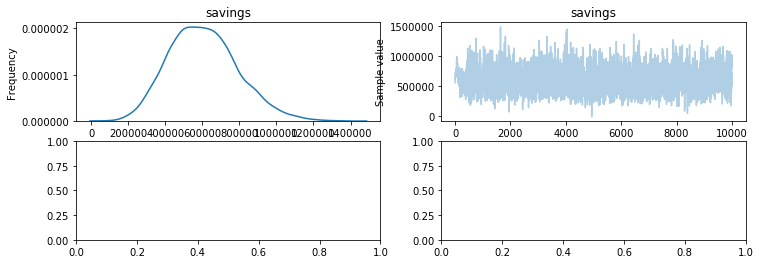

In [82]:
pm.plots.traceplot(trace, varnames=["savings", "buy_loss"])
pm.plots.plot_posterior(trace, varnames=["savings", "buy_loss"], kde_plot=True)

In [59]:
??np.linspace()

In [68]:
sims = pd.DataFrame(trace['savings'], columns=['savings'])

def break_even_prob(sims):
    return (sims > 400000).sum()/sims.shape[0]

def decision_loss(sims):
    sims["Buy Loss"] = np.where(sims.savings >= 400000, 0, 400000 - sims.savings)
    sims["Don't Buy Loss"] = np.where(sims.savings >= 400000, sims.savings - 400000, 0)
    return sims

def expected_opportunity_loss(sims, decision):
    buckets = pd.DataFrame(np.linspace(0, 1400000, num=14000), columns=["low"])
    buckets['high'] = buckets.low.shift(-1)
    return buckets[:-1]
    

# break_even_prob(sims)
buckets = expected_opportunity_loss(sims, "Buy Loss")
buckets['p']

Now that we have calculated that probability of at least breaking even, 86.48%, we can calculate the Expected Value of Perfect Information.  To do this we need to lay out the decision and loss.

| Decision | Savings >= 400,000 | Savings < 400,000 |
|:--------:|:------------------:|:-----------------:|
|          |       p = .86      |      p = .14      |
| Buy Machine | 0 | 400,000 - Savings |
| Don't Buy | Savings - 400,000 | 0 |

In [55]:
losses = decision_loss(sims)
print("Buy Average Loss"losses

,savings,Buy Loss,Don't Buy Loss
0,578897.222648,0.000000,178897.222648
1,559160.498121,0.000000,159160.498121
2,597272.205678,0.000000,197272.205678
3,624552.512619,0.000000,224552.512619
4,577244.190666,0.000000,177244.190666
5,541013.141138,0.000000,141013.141138
6,588774.210789,0.000000,188774.210789
7,560475.397667,0.000000,160475.397667
8,578711.372174,0.000000,178711.372174
9,575950.269525,0.000000,175950.269525


In [46]:
??pd.DataFrame